In [8]:
import pandas as pd
import numpy as np
data = pd.read_csv("raw_data.csv")
series_col = "Close_2330.TW"
exog_cols = [col for col in data.columns if col not in [series_col, "Date"]]
orig_dates = data.index.copy()
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date').sort_index()
full_index = pd.date_range(start=data.index.min(), end=data.index.max(), freq='D')
data_full = data.reindex(full_index)
price_cols = [c for c in data_full.columns if 'Close' in c]
volume_cols = [c for c in data_full.columns if 'Volume' in c]
return_cols = [c for c in data_full.columns if 'Return' in c]
data_full = data_full.iloc[3:]
# If you want to mark weekends explicitly:
data_full[price_cols] = data_full[price_cols].ffill()
data_full[volume_cols] = data_full[volume_cols].fillna(0)
data_full[return_cols] = data_full[return_cols].fillna(0)
data_full['is_weekend'] = data_full.index.dayofweek >= 5
data = data_full
data = data.sort_index()
y = data[series_col]
x = data[exog_cols]
test_size = int(0.1*len(data))
y_train = y[:-test_size]
y_test = y[-test_size:]
x_train = x[:-test_size]
x_test = x[-test_size:]
# {'n_estimators': 974, 'learning_rate': 0.13426655360375864, 'max_depth': 9, 'min_child_weight': 1.5589137266673745, 'subsample': 0.5820879068561218, 'colsample_bytree': 0.8999973640922538, 'gamma': 0.0028034124472899324, 'reg_alpha': 0.10741448351807012, 'reg_lambda': 0.21986707100607256}


In [9]:
import optuna
from catboost import CatBoostRegressor
from skforecast.recursive import ForecasterRecursive
from skforecast.preprocessing import RollingFeatures
from xgboost import XGBRegressor
from sklearn.preprocessing import PowerTransformer
from skforecast.model_selection import TimeSeriesFold, backtesting_forecaster
from sklearn.exceptions import ConvergenceWarning
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
import warnings
from skforecast.exceptions import DataTypeWarning
warnings.simplefilter('ignore', category=DataTypeWarning)
warnings.simplefilter('ignore', category=ConvergenceWarning)

def objective(trial):
    # Suggest key CatBoost hyperparameters
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 200, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_weight': trial.suggest_float('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0.0, 5.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.1, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.1, 10.0, log=True),
        'random_state': 42,
        'tree_method': 'exact'  # fast and memory-efficient
    }

    forecaster = ForecasterRecursive(
                 regressor       = XGBRegressor(**params),
                 lags            = 8,
                 window_features = RollingFeatures(stats=['mean'], window_sizes=[15]),
                 transformer_y   = PowerTransformer(method="box-cox"))
    metrics = [
        # 'mean_absolute_error',
        'root_mean_squared_scaled_error',
        # 'mean_absolute_percentage_error',
        # 'mean_absolute_scaled_error'
    ]
    tscv = TimeSeriesFold(
        steps=30,                 # predict 30 days at a time
        initial_train_size=128,   # start with 1 year of data
        refit=True,
        window_size=10
    )
    backtest_metrics, predictions = backtesting_forecaster(
                                        forecaster = forecaster,
                                        y          = y_train,
                                        cv         = tscv,
                                        metric     = metrics,
                                        exog=x_train,
                                        show_progress=False)
    
    return backtest_metrics.values.item()

In [10]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=1000)

[I 2025-09-13 16:49:06,161] A new study created in memory with name: no-name-3a915116-5acf-4fbf-bedb-b33a0e294fe8
[I 2025-09-13 16:49:10,645] Trial 0 finished with value: 5.366783194249179 and parameters: {'n_estimators': 363, 'learning_rate': 0.12260564014316112, 'max_depth': 9, 'min_child_weight': 7.568918973968788, 'subsample': 0.6590425033622274, 'colsample_bytree': 0.5956580747460483, 'gamma': 4.022975591431562, 'reg_alpha': 7.8059773356740285, 'reg_lambda': 1.9549682525265855}. Best is trial 0 with value: 5.366783194249179.
[I 2025-09-13 16:49:11,438] Trial 1 finished with value: 4.597847265800907 and parameters: {'n_estimators': 625, 'learning_rate': 0.031421213790412045, 'max_depth': 3, 'min_child_weight': 6.294529355997026, 'subsample': 0.9992613291260084, 'colsample_bytree': 0.6818252584676907, 'gamma': 2.0957447161375424, 'reg_alpha': 1.0232140892268478, 'reg_lambda': 0.13803249820964192}. Best is trial 1 with value: 4.597847265800907.
[I 2025-09-13 16:49:12,416] Trial 2 fin

In [72]:
forecaster.fit(y_train, x_train)
predictions = forecaster.predict(steps=len(y_test), exog=x_test[exog_cols])

Learning rate set to 0.036567
0:	learn: 102.4267772	total: 3.46ms	remaining: 3.45s
1:	learn: 99.3026563	total: 6.4ms	remaining: 3.19s
2:	learn: 96.4087772	total: 9.25ms	remaining: 3.07s
3:	learn: 93.5508763	total: 12.6ms	remaining: 3.13s
4:	learn: 90.8261432	total: 15.7ms	remaining: 3.13s
5:	learn: 88.0171479	total: 19.4ms	remaining: 3.21s
6:	learn: 85.5389670	total: 22.4ms	remaining: 3.18s
7:	learn: 82.9948508	total: 25.3ms	remaining: 3.14s
8:	learn: 80.5392791	total: 28.4ms	remaining: 3.13s
9:	learn: 78.3054158	total: 31.7ms	remaining: 3.14s
10:	learn: 75.9479711	total: 35ms	remaining: 3.15s
11:	learn: 73.8003469	total: 38.1ms	remaining: 3.14s
12:	learn: 71.7183242	total: 41.1ms	remaining: 3.12s
13:	learn: 69.6102021	total: 44.1ms	remaining: 3.11s
14:	learn: 67.5645138	total: 47.4ms	remaining: 3.11s
15:	learn: 65.6766105	total: 50.5ms	remaining: 3.11s
16:	learn: 63.9221019	total: 53.4ms	remaining: 3.08s
17:	learn: 62.2230756	total: 56.3ms	remaining: 3.07s
18:	learn: 60.5523775	total:

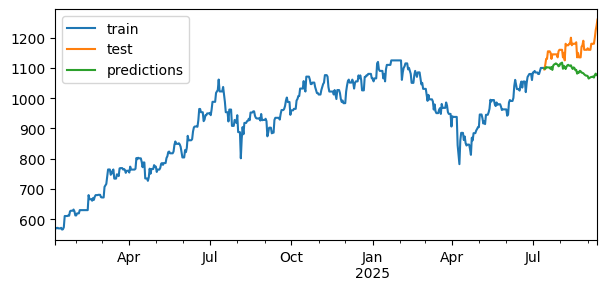

In [73]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(7, 3))
y_train.plot(ax=ax, label='train')
y_test.plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend()

In [115]:
from sklearn.metrics import root_mean_squared_error
y_true = data_test[series_col].values
y_pred = predictions.values
error = root_mean_squared_error(y_true, y_pred)
print(error)

5.933721189022128
